In [1]:
# %load std_libraries.py
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\\heine\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)

if sys.path[-1] != base_dir:
    sys.path.append(base_dir)
    print("Added " + base_dir + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook
data_processing_dir = base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
#import pickle
#import subprocess
#import networkx as nx
# import scipy.stats as stats
import scipy.cluster.hierarchy as sch

# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

from collections import Counter
# import scipy.stats as stats
# from itertools import chain
#this only works if you are online
online_input = input("are you online? Yes/No")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')


what computer are you on? a = Bens, b = gpucluster, c = other   b
base directory is /home/heineike/github/expression_broad_data
Added /home/heineike/github/expression_broad_data to path: 
['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/usr/local/lib/python3.5/dist-packages', '/usr/local/lib/python3.5/dist-packages/cmonkey2-1.2.6-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/SQLAlchemy_Utils-0.32.14-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/svgwrite-1.1.11-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/Routes-2.4.1-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/CherryPy-10.2.2-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/biopython-1.69-py3.5-linux-x86_64.egg', '/usr/local/lib/python3.5/dist-packages/configparser-3.5.0-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/rpy2-2.8.6-py3.5-linux-x86_64.egg', '/usr/local/lib/python3.5/dist-packages/repoze.lru-0.6-py3.5.egg', '

In [2]:
#Load raw count data from Solis Dataset.  Plot alongside fold change. 
fname_solis_SC_PKA_counts_pkl = os.path.normpath(base_dir + '\expression_data\SCer_NMPP1_RNA_Seq\solis_2016_counts.pkl')
solis_counts = pd.read_pickle(fname_solis_SC_PKA_counts_pkl)


In [60]:
#Process Msn24 delete data from Solis dataset: 

#Ran STAR on the GPU cluster /home/heineike/star_scripts/20170412_solis_2016_counts.sh
#moved count output to local directory base_dir + '\expression_data\SCer_NMPP1_RNA_Seq\'

# #Merge output into single flat file and save. 

# #Keep only the second column - this is stranded data so this corresponds to the strand that is listed in the GFF file. 

condition_barcodes = {'AS_cont' : 'GATCAG', 'AS_HS': 'TAGCTT', 'AS_1NMPP1': 'GGCTAC', 'AS_1NMPP1plusHS': 'CTTGTA', 'msn24del_cont': 'ATCACG', 'msn24del_HS': 'CGATGT', 'msn24del_1NMPP1': 'TTAGGC', 'G19V_cont': 'ACAGTG', 'G19V_HS': 'GCCAAT'}

# dictionary to collect? 
solis_counts_msn24_dict = {}
for condition, barcode in condition_barcodes.items(): 
    solis_counts_msn24_full = pd.read_table(os.path.normpath(data_processing_dir + 'SCer_NMPP1_RNA_Seq\\solis_2016_msn24del\\' + barcode + '-s_7_1_sequence_ReadsPerGene.out.tab'), index_col = 0, header = None)
    #take the second column which is for stranded library preparation protocols
    solis_counts_msn24_raw = solis_counts_msn24_full.loc[:,1]
    #remove the metadata rows
    rows_to_remove = ['N_unmapped','N_multimapping','N_noFeature','N_ambiguous']
    solis_counts_msn24_cond = solis_counts_msn24_raw.drop(rows_to_remove)                                
    solis_counts_msn24_dict[condition] = solis_counts_msn24_cond                                                

                                     
solis_counts_msn24 = pd.DataFrame(solis_counts_msn24_dict)
        
#add up the counts and normalize by total - then multiplies by the mean number of counts to get a number on the same scale 
#as original counts.  
total_reads = solis_counts_msn24.sum()
for condition in solis_counts_msn24_dict.keys(): 
    norm_reads = (solis_counts_msn24[condition]*np.mean(total_reads))/total_reads[condition]
    solis_counts_msn24[condition + '_norm'] = norm_reads

solis_counts_msn24

#Save data wih fold change and control/exp counts.  
fname_solis_SC_PKA_counts_msn24 = os.path.normpath(data_processing_dir + 'SCer_NMPP1_RNA_Seq\solis_2016_counts_msn24.csv')
solis_counts_msn24.to_csv(fname_solis_SC_PKA_counts_msn24)




<IPython.core.display.Javascript object>


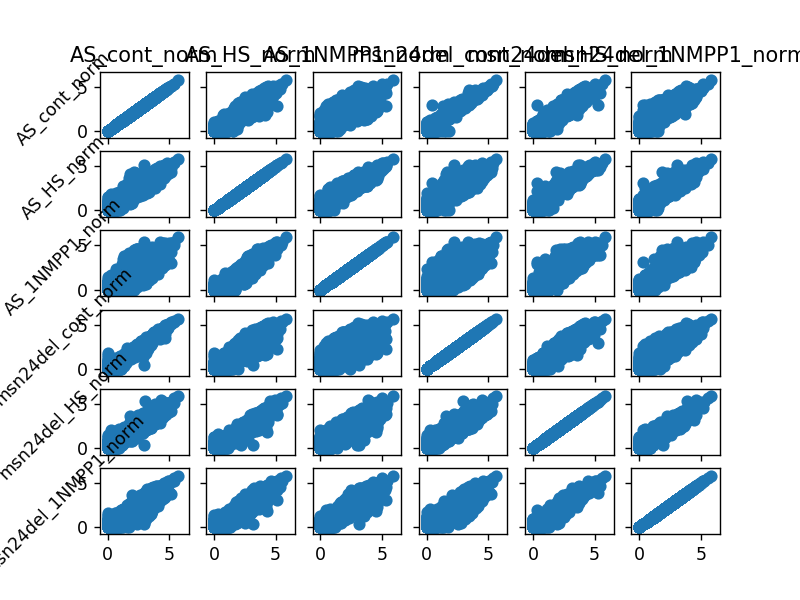

In [27]:
#Make sure this new data is internally consistent and also consistent with older solis count data

#Correlation plots
columns_to_plot = ['AS_cont_norm', 'AS_HS_norm','AS_1NMPP1_norm','msn24del_cont_norm', 'msn24del_HS_norm', 'msn24del_1NMPP1_norm']
pseudocount = 1
#extract columns, add in pseudocount, and take log
data_to_plot = (solis_counts_msn24.loc[:,columns_to_plot]+ pseudocount).apply(np.log10)

fig, axarr = expression_plots.multi_scatter_plot(data_to_plot, columns_to_plot)

<IPython.core.display.Javascript object>


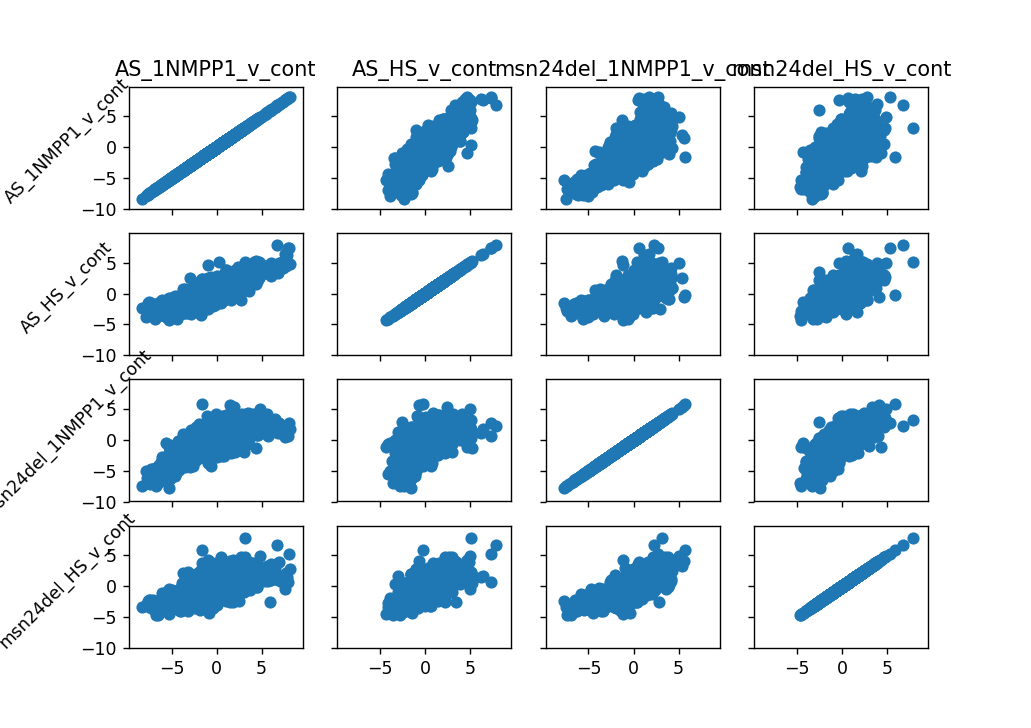

In [32]:
#Calculate fold change (might be nice to use DESEQ eventually, but initially just divide)

fold_change_pairs = {'AS_1NMPP1_v_cont': ('AS_1NMPP1_norm','AS_cont_norm'), 'AS_HS_v_cont': ('AS_HS_norm', 'AS_cont_norm'), 
                     'msn24del_1NMPP1_v_cont': ('msn24del_1NMPP1_norm','msn24del_cont_norm'),
                     'msn24del_HS_v_cont': ('msn24del_HS_norm','msn24del_cont_norm')}

pseudocount = 1

fold_change_dict = {}
for key, pair in fold_change_pairs.items(): 
    pair_data = solis_counts_msn24.loc[:,pair] + pseudocount
    log_fc = np.log(pair_data[pair[0]]/pair_data[pair[1]])/np.log(2)
    fold_change_dict[key] = log_fc

fold_change = pd.DataFrame(fold_change_dict)

fig, axarr = expression_plots.multi_scatter_plot(fold_change, fold_change.columns)



In [36]:
#Load my LFC data

lfc_data = pd.read_csv(data_processing_dir + os.path.normpath("20170817_klscpka/20170817_klscpka_DESEQ_YPD_t40_AsMinvAsPlus_SC.csv"))
lfc_data.rename(columns = {'Unnamed: 0':'sc_genename'},inplace = True)


In [46]:
# The genenames for my set and for the solis data are the same (I used the same genome in star to get the counts so not surprising.)
print(len(set(lfc_data['sc_genename'])))
print(len(set(fold_change.index)))
print(len(set(lfc_data['sc_genename'])-set(fold_change.index)))


6692
6692
0


<IPython.core.display.Javascript object>


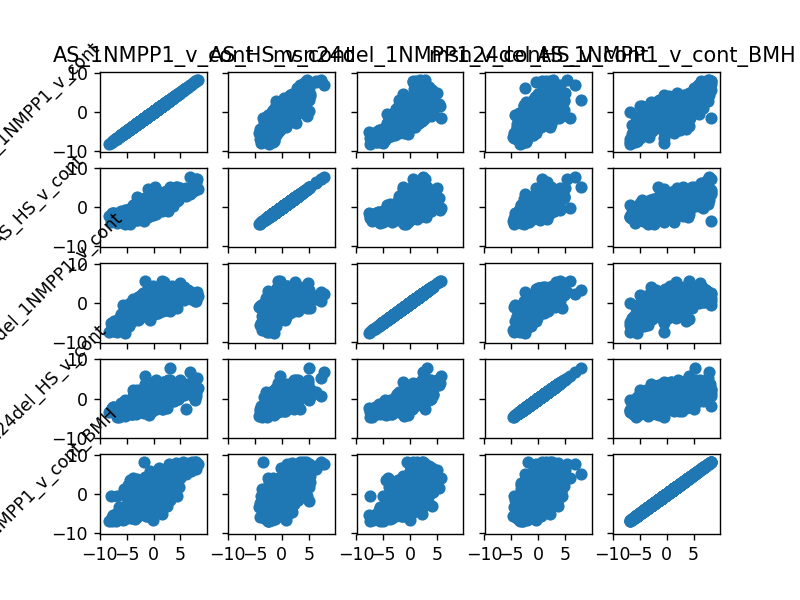

In [58]:

#Add my data to fold_change dataframe
fold_change_combined = pd.merge(fold_change,lfc_data.loc[:,['sc_genename','log2FoldChange']],how = 'inner', left_index=True, right_on='sc_genename')
fold_change_combined.set_index('sc_genename', inplace=True)
fold_change_combined.rename(columns = {'log2FoldChange':'AS_1NMPP1_v_cont_BMH'},inplace=True)

fig, axarr = expression_plots.multi_scatter_plot(fold_change_combined, fold_change_combined.columns)

In [11]:
kl_sc_PKA_data.columns

Index(['N SCer Orthologs', 'kl_genename', 'sc_genename', 'baseMean_KL',
       'log2FoldChange_KL', 'lfcSE_KL', 'stat_KL', 'pvalue_KL', 'padj_KL',
       'rlog_AS_noNMPP1_YPD_t40_mean_KL', 'rlog_AS_yesNMPP1_YPD_t40_mean_KL',
       'rlog_AS_noNMPP1_YPD_t40_var_KL', 'rlog_AS_yesNMPP1_YPD_t40_var_KL',
       'raw_AS_noNMPP1_YPD_t40_mean_KL', 'raw_AS_yesNMPP1_YPD_t40_mean_KL',
       'raw_AS_noNMPP1_YPD_t40_var_KL', 'raw_AS_yesNMPP1_YPD_t40_var_KL',
       'baseMean_SC', 'log2FoldChange_SC', 'lfcSE_SC', 'stat_SC', 'pvalue_SC',
       'padj_SC', 'rlog_AS_noNMPP1_YPD_t40_mean_SC',
       'rlog_AS_yesNMPP1_YPD_t40_mean_SC', 'rlog_AS_noNMPP1_YPD_t40_var_SC',
       'rlog_AS_yesNMPP1_YPD_t40_var_SC', 'raw_AS_noNMPP1_YPD_t40_mean_SC',
       'raw_AS_yesNMPP1_YPD_t40_mean_SC', 'raw_AS_noNMPP1_YPD_t40_var_SC',
       'raw_AS_yesNMPP1_YPD_t40_var_SC', 'SC_common_name'],
      dtype='object')

## Msn24 delete data

In [2]:
#Load my data
fname_cross_spec_comparison = data_processing_dir + os.path.normpath("20170817_klscpka/cross_species_compare_ASminus_ASplus_YPD.csv")
kl_sc_PKA_data = pd.read_csv(fname_cross_spec_comparison, index_col=0)


In [7]:
#plot rlog of AS NMPP1 and msn24del NMPP1 data and highlight my gois on top

#load rlog data
rlog_data = pd.read_csv(data_processing_dir + os.path.normpath('SCer_NMPP1_RNA_Seq/solis_2016_msn24_rlog.csv'))
rlog_data.rename(columns = {'Unnamed: 0': 'sc_genename'}, inplace = True)
rlog_data['SC_common_name'] = io_library.SC_common_name_lookup(list(rlog_data['sc_genename']))

# Load goi data from goi data file created in paralog analysis script. 
goi_data = pd.read_csv(data_processing_dir + os.sep + "20170817_klscpka" + os.sep + "goi_data.csv")


In [3]:
#control: Plot rlog of my data v.s. solis nmpp1 data

#want to do scatter of 






# trace1 = go.Scatter(
#     x=[1, 2, 3],
#     y=[4, 5, 6]
# )
# trace2 = go.Scatter(
#     x=[20, 30, 40],
#     y=[50, 60, 70],
# )

# fig = tools.make_subplots(rows=1, cols=2)

# fig.append_trace(trace1, 1, 1)
# fig.append_trace(trace2, 1, 2)

# fig['layout'].update(height=600, width=600, title='i <3 subplots')
# py.iplot(fig, filename='simple-subplot')

,N SCer Orthologs,kl_genename,sc_genename,baseMean_KL,log2FoldChange_KL,lfcSE_KL,stat_KL,pvalue_KL,padj_KL,rlog_AS_noNMPP1_YPD_t40_mean_KL,...,padj_SC,rlog_AS_noNMPP1_YPD_t40_mean_SC,rlog_AS_yesNMPP1_YPD_t40_mean_SC,rlog_AS_noNMPP1_YPD_t40_var_SC,rlog_AS_yesNMPP1_YPD_t40_var_SC,raw_AS_noNMPP1_YPD_t40_mean_SC,raw_AS_yesNMPP1_YPD_t40_mean_SC,raw_AS_noNMPP1_YPD_t40_var_SC,raw_AS_yesNMPP1_YPD_t40_var_SC,SC_common_name
0,1,KLLA0E08273g,YIL093C,307.097324,-3.117319,0.391869,-7.955013,1.791132e-15,2.616525e-14,8.023578,...,7.999032e-01,5.864384,6.012012,0.102512,0.153527,1.795921,1.975034,0.026258,0.019171,RSM25
1,1,KLLA0E02179g,YNL323W,596.750877,-0.487211,0.413954,-1.176970,2.392077e-01,3.662996e-01,8.748092,...,8.144010e-01,6.841067,6.690319,1.983754,1.266548,2.075730,2.146700,0.219432,0.176372,LEM3
2,1,KLLA0F12056g,YKR076W,721.339292,5.725890,0.404135,14.168246,1.440529e-45,4.800564e-43,5.529407,...,7.773336e-48,4.965655,8.642741,0.007693,0.014076,1.384101,2.853356,0.005008,0.001150,ECM4
3,1,KLLA0E19691g,YDL174C,32.292002,-0.704536,0.665985,-1.057885,2.901077e-01,4.257787e-01,4.606895,...,1.003400e-10,8.842651,10.535558,0.078743,0.013612,2.609322,3.352513,0.022757,0.002677,DLD1
4,1,KLLA0F20273g,YOR163W,373.122032,0.991374,0.372431,2.661898,7.770147e-03,2.074633e-02,7.353489,...,5.395452e-08,7.264692,8.645844,0.001013,0.063187,2.172017,2.797982,0.001943,0.009904,DDP1
5,1,KLLA0D06127g,YOR246C,300.550233,-0.868219,0.396272,-2.190966,2.845426e-02,6.324328e-02,7.852620,...,5.789574e-07,8.839137,7.382572,0.069640,0.105390,2.717814,2.313137,0.019736,0.016472,ENV9
6,1,KLLA0E07063g,YOL137W,1070.413296,-0.255403,0.442553,-0.577113,5.638634e-01,6.923888e-01,9.647924,...,2.203476e-01,7.471431,7.053748,0.146176,0.083442,2.273729,2.246661,0.008723,0.014864,BSC6
7,1,KLLA0F04499g,YNL067W,938.472171,-4.275055,0.414509,-10.313529,6.121162e-25,2.190472e-23,9.664893,...,1.370800e-11,10.372920,8.550739,0.148571,0.018560,3.156162,2.610781,0.008638,0.004957,RPL9B
8,1,KLLA0C15257g,YDR237W,1161.638190,-2.706933,0.385808,-7.016270,2.278691e-12,2.454541e-11,9.964306,...,7.555303e-01,8.014269,8.158493,0.047859,0.077205,2.434586,2.612835,0.015225,0.008768,MRPL7
9,1,KLLA0E08867g,YNL015W,2927.423587,4.691308,0.454999,10.310592,6.311116e-25,2.243391e-23,7.896321,...,3.481628e-18,3.787630,7.135544,0.127834,0.293084,0.997871,2.378694,0.029605,0.032591,PBI2


In [45]:
#Plot Solis data v.s. my data
solis_data_list = ['AS', 'msn24del']

kl_sc_PKA_data_solis = kl_sc_PKA_data.copy()
for dataset in solis_data_list: 
    #Load solis data
    new_data = pd.read_csv(data_processing_dir + os.path.normpath('SCer_NMPP1_RNA_Seq/solis_2016_'+ dataset + '_nmpp1_deseq2.csv'))
    new_data.rename(columns = {'Unnamed: 0': 'sc_genename'}, inplace = True)
    columns_to_keep = ['sc_genename','log2FoldChange','baseMean','padj']
    kl_sc_PKA_data_solis = kl_sc_PKA_data_solis.merge(new_data.loc[:,columns_to_keep], how = 'outer', on = 'sc_genename', suffixes = ('','_'+dataset))
columns_to_keep.remove('sc_genename')
kl_sc_PKA_data_solis.rename(columns = {column:column+'_AS' for column in columns_to_keep },inplace = True )

In [50]:
new_data = pd.read_csv(data_processing_dir + os.path.normpath('SCer_NMPP1_RNA_Seq/solis_2016_msn24del_nmpp1_deseq2_onlystraindata.csv'))
new_data.rename(columns = {'Unnamed: 0': 'sc_genename'}, inplace = True)
columns_to_keep = ['sc_genename','log2FoldChange','baseMean','padj']
kl_sc_PKA_data_solis = kl_sc_PKA_data_solis.merge(new_data.loc[:,columns_to_keep], how = 'outer', on = 'sc_genename')
columns_to_keep.remove('sc_genename')
kl_sc_PKA_data_solis.rename(columns = {column:column+'_msn24_onlystraindata' for column in columns_to_keep },inplace = True )

In [51]:
kl_sc_PKA_data_solis.columns

Index(['N SCer Orthologs', 'kl_genename', 'sc_genename', 'baseMean_KL',
       'log2FoldChange_KL', 'lfcSE_KL', 'stat_KL', 'pvalue_KL', 'padj_KL',
       'rlog_AS_noNMPP1_YPD_t40_mean_KL', 'rlog_AS_yesNMPP1_YPD_t40_mean_KL',
       'rlog_AS_noNMPP1_YPD_t40_var_KL', 'rlog_AS_yesNMPP1_YPD_t40_var_KL',
       'raw_AS_noNMPP1_YPD_t40_mean_KL', 'raw_AS_yesNMPP1_YPD_t40_mean_KL',
       'raw_AS_noNMPP1_YPD_t40_var_KL', 'raw_AS_yesNMPP1_YPD_t40_var_KL',
       'baseMean_SC', 'log2FoldChange_SC', 'lfcSE_SC', 'stat_SC', 'pvalue_SC',
       'padj_SC', 'rlog_AS_noNMPP1_YPD_t40_mean_SC',
       'rlog_AS_yesNMPP1_YPD_t40_mean_SC', 'rlog_AS_noNMPP1_YPD_t40_var_SC',
       'rlog_AS_yesNMPP1_YPD_t40_var_SC', 'raw_AS_noNMPP1_YPD_t40_mean_SC',
       'raw_AS_yesNMPP1_YPD_t40_mean_SC', 'raw_AS_noNMPP1_YPD_t40_var_SC',
       'raw_AS_yesNMPP1_YPD_t40_var_SC', 'SC_common_name', 'log2FoldChange_AS',
       'baseMean_AS', 'padj_AS', 'log2FoldChange_msn24del',
       'baseMean_msn24del', 'padj_msn24del',
    

In [52]:

# hover_text = []
# for ind, row in kl_sc_PKA_data.iterrows():
#     hover_text.append(('{SC_common_name}<br>').format(SC_common_name=row['SC_common_name']))

trace = pygo.Scatter(
    x = kl_sc_PKA_data_solis['log2FoldChange_msn24del'],
    y =  kl_sc_PKA_data_solis['log2FoldChange_msn24_onlystraindata'],
    text = kl_sc_PKA_data_solis['SC_common_name'],
    mode = 'markers'
)

data = [trace]


py.iplot(data, filename='solis_data_comparison')

In [94]:
goi_list_high = list(goi_data[(goi_data['category'].isin(['metabolic','regulatory'])) & (goi_data['log2FoldChange_SC']>2.0)]['sc_genename'])
goi_list_lowflat = list(goi_data[(goi_data['category'].isin(['metabolic','regulatory'])) & (goi_data['log2FoldChange_SC']<2.0)]['sc_genename'])

# hover_text = []
# for ind, row in kl_sc_PKA_data.iterrows():
#     hover_text.append(('{SC_common_name}<br>').format(SC_common_name=row['SC_common_name']))

rlog_data_goi_up = rlog_data[rlog_data['sc_genename'].isin(goi_list_high)]
rlog_data_goi_lowflat = rlog_data[rlog_data['sc_genename'].isin(goi_list_lowflat)]
rlog_data_nogoi = rlog_data[~rlog_data['sc_genename'].isin(goi_list_high+goi_list_lowflat)]

trace1 = pygo.Scatter(
    x = rlog_data_goi_up['AS_1NMPP1'],
    y =  rlog_data_goi_up['msn24del_1NMPP1'],
    text = rlog_data_goi_up['SC_common_name'],
    mode = 'markers',
    marker = {'opacity': 0.5, 'color': 'red'},
    name = 'GOI High LFC'
)

trace2 = pygo.Scatter(
    x = rlog_data_goi_lowflat['AS_1NMPP1'],
    y =  rlog_data_goi_lowflat['msn24del_1NMPP1'],
    text = rlog_data_goi_lowflat['SC_common_name'],
    mode = 'markers',
    marker = {'opacity': 0.5, 'color': 'blue'},
    name = 'GOI Low/Flat LFC'
)

trace3 = pygo.Scatter(
    x = rlog_data_nogoi['AS_1NMPP1'],
    y =  rlog_data_nogoi['msn24del_1NMPP1'],
    text = rlog_data_nogoi['SC_common_name'],
    mode = 'markers',
    marker = {'opacity': 0.1, 'color': 'gray'},
    name = 'non-GOI'
)

data = [trace1,trace2,trace3]

layout = pygo.Layout(
    xaxis= {
        "range":[-2, 20],
        "title":'solis AS + 1NMPP1'
    },
    yaxis= {
        "range":[-2, 20],
        "title":'solis AS msn24del + 1NMPP1'
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename='solis_msn24_NMPP1_rlog_comparison')

How is any Msn2 and Msn4 expression getting counted??

RGI1 and RGI2 both low here - this seems to disagree with my data about that gene. I have RGI2 very low.  This has RGI1 lower. 

Surprised at how many of the low/flat group is effected by Msn2/4 deletion.  
Almost all of the activated cloud are effected by Msn24 deletion.  

Question is how much of this is just a Msn24 deletion effect. 


In [9]:
#volcano plot of interaction term with my colors superimposed
#load deseq data
interaction_data = pd.read_csv(data_processing_dir + os.path.normpath('SCer_NMPP1_RNA_Seq/solis_2016_msn24del_nmpp1_interaction_deseq2.csv'))
interaction_data.rename(columns = {'Unnamed: 0': 'sc_genename'}, inplace = True)
interaction_data['SC_common_name'] = io_library.SC_common_name_lookup(list(interaction_data['sc_genename']))



In [102]:
goi_list_high = list(goi_data[(goi_data['category'].isin(['metabolic','regulatory'])) & (goi_data['log2FoldChange_SC']>2.0)]['sc_genename'])
goi_list_lowflat = list(goi_data[(goi_data['category'].isin(['metabolic','regulatory'])) & (goi_data['log2FoldChange_SC']<2.0)]['sc_genename'])

# hover_text = []
# for ind, row in kl_sc_PKA_data.iterrows():
#     hover_text.append(('{SC_common_name}<br>').format(SC_common_name=row['SC_common_name']))

interaction_data_goi_up = interaction_data[interaction_data['sc_genename'].isin(goi_list_high)]
interaction_data_goi_lowflat = interaction_data[interaction_data['sc_genename'].isin(goi_list_lowflat)]
interaction_data_nogoi = interaction_data[~interaction_data['sc_genename'].isin(goi_list_high+goi_list_lowflat)]

trace1 = pygo.Scatter(
    x = interaction_data_goi_up['log2FoldChange'],
    y =  -np.log10(interaction_data_goi_up['pvalue']),
    text = interaction_data_goi_up['SC_common_name'],
    mode = 'markers',
    marker = {'opacity': 0.5, 'color': 'red'},
    name = 'GOI High LFC'
)

trace2 = pygo.Scatter(
    x = interaction_data_goi_lowflat['log2FoldChange'],
    y =  -np.log10(interaction_data_goi_lowflat['pvalue']),
    text = interaction_data_goi_lowflat['SC_common_name'],
    mode = 'markers',
    marker = {'opacity': 0.5, 'color': 'blue'},
    name = 'GOI Low/Flat LFC'
)

trace3 = pygo.Scatter(
    x = interaction_data_nogoi['log2FoldChange'],
    y =  -np.log10(interaction_data_nogoi['pvalue']),
    text = interaction_data_nogoi['SC_common_name'],
    mode = 'markers',
    marker = {'opacity': 0.1, 'color': 'gray'},
    name = 'non-GOI'
)

data = [trace1,trace2,trace3]

layout = pygo.Layout(
    xaxis= {
        "range":[-10, 10],
        "title":'interaction term LFC'
    },
    yaxis= {
        "range":[-0.1, 1.5],
        "title":'interaction term pvalue'
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename='solis_msn24_interaction_volcano')

ENO1 seems to be on the wrong side and YOL024W seems to be on the wrong side. 

In [55]:
new_data = pd.read_csv(data_processing_dir + os.path.normpath('SCer_NMPP1_RNA_Seq/solis_2016_msn24del_nmpp1_interaction_deseq2.csv'))
new_data.rename(columns = {'Unnamed: 0': 'sc_genename'}, inplace = True)

# columns_to_keep = ['sc_genename','log2FoldChange','baseMean','padj']
# kl_sc_PKA_data_solis = kl_sc_PKA_data_solis.merge(new_data.loc[:,columns_to_keep], how = 'outer', on = 'sc_genename')
# columns_to_keep.remove('sc_genename')
# kl_sc_PKA_data_solis.rename(columns = {column:column+'_msn24_onlystraindata' for column in columns_to_keep },inplace = True )

KeyError: 'pval'

In [15]:
#Add interaction column and rlog columns from solis data to goi_data

#Add interaction columns

goi_data_solis = goi_data.merge(interaction_data.loc[:,['sc_genename','log2FoldChange','pvalue']],how = 'left', on = 'sc_genename')
goi_data_solis.rename(columns = {'log2FoldChange': 'log2FoldChange_msn24del_interaction', 'pvalue':'pvalue_msn24del_interaction'},inplace = True)
goi_data_solis.to_csv(data_processing_dir + os.path.normpath('20170817_klscpka/goi_data_solis.csv'))




## Check promoters for induced, non Msn2/4 genes and repressed Msn2/4 genes

In [33]:
#Read in the SC promoter database.  
sc_promoters = pd.read_pickle(data_processing_dir + os.path.normpath("sc_promoters/sc_promoters.pkl"))

#Add in Cox5b gene: 
Cox5b_prom = 'AAACTTTGATGGGGTTGATTTGGACACAAAGATTGGGTATGAGCTTTTGGAGTACAAAAAATTTGTTAGTTTGCCCATGGCGTGGATTAAATGGGATAACGTTGTTATTGAAAACCACGCAAAAAGAAAAGAAATTGAAGGAAATATGATTCAAATATCAATAAACGAATTTGCACGATGGAGAAACGATAAGCTGAACAAAGCGCAGCAGCCGACGCGCAAACAGCGTTCTCTAAAAATACCTCGAGAGTTACCGGTTAAATTTCAACACCGTATGAGCATATCCTCCGTCCTCCAGCAGACATCCAAAGAACCATTTTGGTAAAACAATTCATCGGTCCGTTGGCATATGCTCATACATAGTTGCATTTTCGATTCATTAAATACTATTCATGTTAACATAATTCCATATAATCGTACTGTTTTGTCATTATTATATCGGCATGACACTCACCAATTTCTTTTTTTGATTTTGTATTGTTCGATAAGGCAACGAACGAGTACTCGAAAAAATGTCATGGACCCCTTAAAATTACTGAGGGGTTCAGAAAATACCGTGCAAAAGACGAAAAAAGACGAATTTCATTTGATTTATATTTTATAAATGACTGTTGCATTAAACAATAGACCAATTATTTCAATTTAATATTCTTTGCAGGAAACTTTCACAATGGAATAACGCCACATATTCATTGTAAAG'
Cox5b_gene = 'AGCATGTATAACAAACACTGATTTTTGTTTTGAGTTTTAAAAGATATCCATTTACTAACATTCGAGGTGTACAAGCACAAGTTTTGCAGTGTTGCGTACTTCTCTTACTAAAGGGGCACGGCTAACTGGGACAAGATTTGTTCAAACAAAGGCCCTTTCGAAGGCAACATTGACAGATCTGCCCGAAAGATGGGAAAATATGCCAAACTTAGAACAGAAAGAGATTGCAGATAATTTGACAGAACGTCAAAAGCTTCCATGGAAAACTCTCAATAACGAGGAAATCAAAGCAGCTTGGTACATATCCTACGGCGAGTGGGGACCTAGAAGACCTGTACACGGAAAAGGCGATGTTGCATTTATAACTAAAGGAGTATTTTTAGGGTTAGGAATCTCATTTGGGCTCTTTGGTTTAGTGAGACTATTAGCCAATCCTGAAACTCCAAAGACTATGAACAGGGAATGGCAGTTGAAATCAGACGAGTATCTGAAGTCAAAAAATGCCAATCCTTGGGGAGGTTATTCTCAAGTTCAATCTAAATAA'
sc_promoters.loc['YIL111W'] = ['COX5B',Cox5b_prom,Cox5b_gene]

#save new file
sc_promoters.to_pickle(data_processing_dir + os.path.normpath("sc_promoters/sc_promoters.pkl"))

In [34]:
goi_data_solis = pd.read_csv(data_processing_dir + os.path.normpath('20170817_klscpka/goi_data_solis.csv'))

#Read in the SC promoter database.  
sc_promoters = pd.read_pickle(data_processing_dir + os.path.normpath("sc_promoters/sc_promoters.pkl"))




In [7]:
#Induced non-Msn2/4 genes
goi_data_category = goi_data_solis[goi_data_solis['category'].isin(['metabolic','regulatory'])]
goi_data_LFC = goi_data_category[goi_data_category['log2FoldChange_SC']>2.0]
goi_data_interaction = goi_data_LFC[goi_data_LFC['log2FoldChange_msn24del_interaction']>1.2]


In [35]:
#build a promoter set for those genes
genes = goi_data_interaction['sc_genename']
target_promoter_fname = data_processing_dir + os.path.normpath('sc_promoters/promoter_sets/paralogs_lfcgt2p0_notmsn24.fasta')
io_library.write_promoter_file(sc_promoters, list(genes),target_promoter_fname)



In [38]:
#Repressed, msn2/4 genes
goi_data_category = goi_data_solis[goi_data_solis['category'].isin(['metabolic','regulatory'])]
goi_data_LFC = goi_data_category[goi_data_category['log2FoldChange_SC']<2.0]
goi_data_interaction = goi_data_LFC[goi_data_LFC['log2FoldChange_msn24del_interaction']>1.2]

In [39]:
#build a promoter set for those genes
genes = goi_data_interaction['sc_genename']
target_promoter_fname = data_processing_dir + os.path.normpath('sc_promoters/promoter_sets/paralogs_lfclt2p0_msn24.fasta')
io_library.write_promoter_file(sc_promoters, list(genes),target_promoter_fname)

In [41]:
goi_data_solis[goi_data_solis['SC_common_name'].isin(['GND1','GND2','TAL1','NQM1','SOL3','SOL4','TKL1','TKL2','GIS1','RPH1'])]

,Unnamed: 0,Unnamed: 0.1,SC_common_name,sc_genename,log2FoldChange_SC,raw_AS_noNMPP1_YPD_t40_mean_SC,pvalue_SC,raw_AS_yesNMPP1_YPD_t40_mean_SC,kl_genename,log2FoldChange_KL,raw_AS_noNMPP1_YPD_t40_mean_KL,raw_AS_yesNMPP1_YPD_t40_mean_KL,pvalue_KL,category,log2FoldChange_msn24del_interaction,pvalue_msn24del_interaction
4,4,3978,GND2,YGR256W,7.143522,1.412570,3.201154e-118,3.676099,KLLA0A09339g,0.394234,3.570254,3.789341,0.275134,metabolic,-4.432623,0.281333
5,5,3979,GND1,YHR183W,-1.190240,2.855015,1.105005e-02,2.639284,KLLA0A09339g,0.394234,3.570254,3.789341,0.275134,metabolic,2.279337,0.243429
24,24,4350,SOL4,YGR248W,7.194901,1.497447,9.975905e-124,3.781944,KLLA0A05390g,1.734949,2.541098,3.161068,0.000003,metabolic,-4.800525,0.300266
25,25,4351,SOL3,YHR163W,-0.150099,2.464830,7.205997e-01,2.523964,KLLA0A05390g,1.734949,2.541098,3.161068,0.000003,metabolic,0.213853,0.790807
44,44,4538,NQM1,YGR043C,6.817958,0.293814,6.185009e-16,2.125423,KLLA0A02607g,-0.307250,3.515193,3.526274,0.377909,metabolic,-4.048476,0.337151
45,45,4539,TAL1,YLR354C,-0.212188,2.363600,8.471294e-01,2.502548,KLLA0A02607g,-0.307250,3.515193,3.526274,0.377909,metabolic,0.585602,0.490930
74,74,4896,TKL2,YBR117C,7.553395,0.378866,1.306362e-28,2.536137,KLLA0B09152g,-1.125151,3.352031,3.072602,0.027631,metabolic,-6.807473,0.157340
75,75,4897,TKL1,YPR074C,-3.322902,3.080331,2.628314e-11,2.236480,KLLA0B09152g,-1.125151,3.352031,3.072602,0.027631,metabolic,2.882744,0.301087
